# Import Modules

In [1]:
import dataset as ds 
import config as cfg
from torch_dataset import TorchDataset

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

from clearml import Task
import clearml
clearml.browser_login()

# ClearML
https://app.clear.ml/dashboard

# GPU Availability

In [2]:
# check GPU availability
print(torch.__version__)
print("CUDA Available: ", torch.cuda.is_available())
print("Device Count: ", torch.cuda.device_count())
print("Current CUDA Device: ", torch.cuda.current_device())
print("Device Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device("cuda")


2.2.2
CUDA Available:  True
Device Count:  1
Current CUDA Device:  0
Device Name:  NVIDIA GeForce RTX 4060 Ti


# Load Dataset

In [3]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test parameters

In [4]:
# name dataset to be create as well as task name
dataset_name = 'test500'

# project and task constant parameters
project_name= cfg.PROJECT_NAME + '/RCNN'
dataset_dir = f'{cfg.RCNN_DATASET_DIR}/{dataset_name}'
project_dir = f'{cfg.RCNN_DATASET_DIR}/{dataset_name}/'
class_names = cfg.RCNN_CLASS_NAMES

# task specifc training parameters
epochs = 20

"""
Methods: 
 - flip
 - rotate
 - bnc
 - gaussian
 - histEq
 - whiteBal
 - sharpen
 - zoom
 - hsv
"""

augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

#augmentation_metadata = {
#    'methods': {        
#        'zoom': {
#            'parameters': {
#                'zoom_factor': 5,  # Could be 'h' for horizontal or 'v' for vertical
#            },
#            'apply_to_percentage': 0.5  # 50% of the training images
#        }        
#    }
#}

# Create Datasets

In [5]:
# create train and validation frames

_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

# create sub dataset
ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)

# augment dataset
ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\RCNN\test500


Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/250 [00:00<?, ?it/s]

An error occurred: In YOLO format all coordinates must be float and in range (0, 1]


In [6]:
from torch.utils.data.dataloader import default_collate

transformations = transforms.Compose([
    transforms.Resize((800, 800)),
    #transforms.Resize(800),
    transforms.ToTensor(), # always required
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# fixes boxes not batching properly
def collate_fn(batch): 
    images = [item[0] for item in batch]
    targets = [{k: v for k, v in item[1].items()} for item in batch]
    images = torch.stack(images, 0)
    return images, targets

# Creating dataset instances for each subset
train_dataset = TorchDataset(dataset_dir, subset='train', transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0,  collate_fn=collate_fn)

train_aug_dataset = TorchDataset(dataset_dir, subset='train-aug', transform=transformations)
train_aug_loader = DataLoader(train_aug_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)

valid_dataset = TorchDataset(dataset_dir, subset='valid', transform=transformations)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)




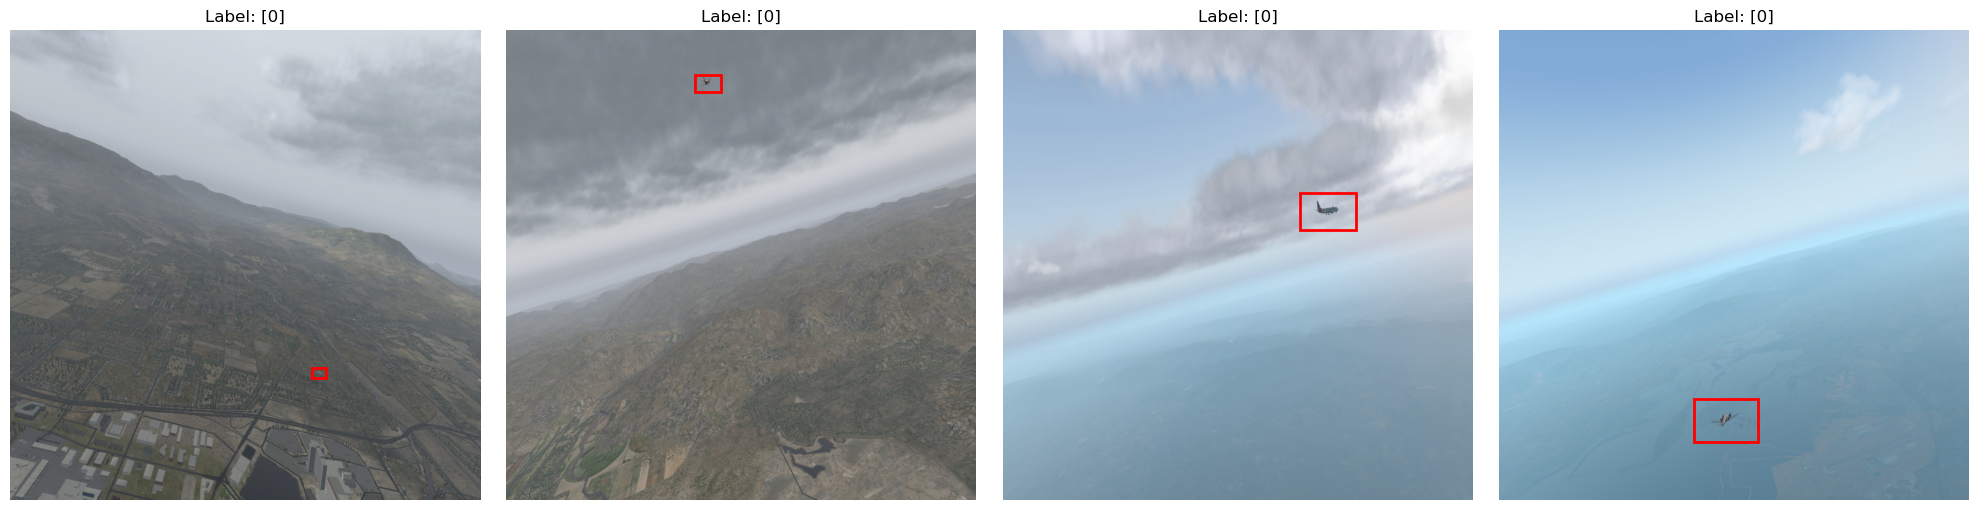

In [7]:
# test to check that new bboxes fit images
def denormalize(tensor, mean, std, inplace=False):
    """Revert the normalization of an image tensor."""
    if not inplace:
        tensor = tensor.clone()

    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    tensor.mul_(std[:, None, None]).add_(mean[:, None, None])
    return tensor

def visualize_samples(dataset, num_samples=4, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Visualize random images and their annotated bounding boxes in a row."""
    # Set the figure size
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))
    
    # Get random indices for images to display
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, ax in zip(indices, axs):
        image, target = dataset[i]
        # Denormalize the image
        image = denormalize(image, mean, std)
        
        # Convert to HxWxC format for matplotlib and display
        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        
        for box in target['boxes']:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Add title and turn off axis
        ax.set_title(f"Label: {target['labels'].tolist()}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize the samples
visualize_samples(train_dataset)



In [8]:
# Assuming you have a dataset instance named 'train_dataset'
sample_image, sample_target = train_dataset[0]
print("Image type:", type(sample_image))
print("Target type:", type(sample_target))

# Check the keys in the target dictionary
if isinstance(sample_target, dict):
    print("Target keys:", sample_target.keys())
else:
    print("The target is not a dictionary. It's a", type(sample_target))


Image type: <class 'torch.Tensor'>
Target type: <class 'dict'>
Target keys: dict_keys(['boxes', 'labels', 'image_id'])


In [9]:
# Print out detailed target information for debugging
for images, targets in train_loader:
    print("Images batch shape:", images.shape)
    print("Targets in batch:", len(targets))
    print("Type of targets:", type(targets))
    if len(targets) > 0:
        # Try printing the first item if targets is a list of dictionaries
        print("Sample target keys:", targets[0].keys())
        print("Sample boxes shape:", targets[0]['boxes'].shape)
    break


Images batch shape: torch.Size([16, 3, 800, 800])
Targets in batch: 16
Type of targets: <class 'list'>
Sample target keys: dict_keys(['boxes', 'labels', 'image_id'])
Sample boxes shape: torch.Size([1, 4])


# Model

In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# Instantiate the model
print("Initiating model ...")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
num_classes = 2  # 1 class (your class) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print("Sending to GPU ...")
# Send the model to the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Instantiate mAP metric from torchmetrics
metric = MeanAveragePrecision()

print("Training model ...")
for epoch in range(epochs):
    model.train()
    for batch_idx, (images, targets) in enumerate(train_loader):
        print(f"batch {batch_idx} ...")
        try:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

        except AttributeError as e:
            print(f"Error in batch {batch_idx}")
            print(f"Targets: {targets}")
            raise e  # Re-raise the exception to stop the loop and see the error

    # You might want to print out the loss here to monitor training
    print(f"Epoch {epoch}: Loss {losses.item()}")
    
    # Validation
    model.eval()
    metric.reset()  # Reset the metric for each epoch
    with torch.no_grad():
        for images, targets in valid_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            # Convert outputs to the format expected by torchmetrics
            preds = [{k: v.detach().cpu() for k, v in t.items()} for t in outputs]
            # Convert targets to the format expected by torchmetrics
            targs = [{k: v.detach().cpu() for k, v in t.items()} for t in targets]

            # Update the metric for each batch
            metric.update(preds, targs)


    # Compute the final metric
    final_mAP = metric.compute()
    # Now you have mAP for all IoU thresholds as a dictionary
    # Extract mAP50 and mAP50-95 if you need to
    map50 = final_mAP['map/iou=0.50'] if 'map/iou=0.50' in final_mAP else None
    map50_95 = final_mAP['map'] if 'map' in final_mAP else None
    
    # Update the learning rate
    lr_scheduler.step()

   ## Print out the training loss and validation mAP
   #print(f'Epoch: {epoch}, Training loss: {losses.item()}, Validation mAP50, mAP50-95: {map50},{map50_95}')



Initiating model ...
Sending to GPU ...
Training model ...
batch 0 ...
batch 1 ...
batch 2 ...
batch 3 ...
batch 4 ...
batch 5 ...
batch 6 ...
batch 7 ...
batch 8 ...
batch 9 ...
batch 10 ...
batch 11 ...
batch 12 ...
batch 13 ...
batch 14 ...
batch 15 ...
batch 16 ...
batch 17 ...
batch 18 ...
batch 19 ...
batch 20 ...
batch 21 ...
batch 22 ...
batch 23 ...
batch 24 ...
batch 25 ...
batch 26 ...
batch 27 ...
batch 28 ...
batch 29 ...
batch 30 ...
batch 31 ...
Epoch 0: Loss 0.07330046594142914


RuntimeError: DataLoader worker (pid(s) 23812, 13040, 27012, 21852) exited unexpectedly